# From Unlabeled Data to a Deployed Machine Learning Model: AWS Ground Truth Demonstration for Image Classification

1. [Introduction](#Introduction)
2. [Run a Ground Truth labeling job (time: about 3h)](#Run-a-Ground-Truth-labeling-job)
    1. [Prepare the data](#Prepare-the-data)
    2. [Specify the categories](#Specify-the-categories)
    3. [Create the instruction template](#Create-the-instruction-template)
    4. [Create a private team to test your task [OPTIONAL]](#Create-a-private-team-to-test-your-task-[OPTIONAL])
    5. [Define pre-built lambda functions for use in the labeling job](#Define-pre-built-lambda-functions-for-use-in-the-labeling-job)
    6. [Submit the Ground Truth job request](#Submit-the-Ground-Truth-job-request)
        1. [Verify your task using a private team [OPTIONAL]](#Verify-your-task-using-a-private-team-[OPTIONAL])
    7. [Monitor job progress](#Monitor-job-progress)
3. [Analyze Ground Truth labeling job results (time: about 20min)](#Analyze-Ground-Truth-labeling-job-results)
    1. [Postprocess the output manifest](#Postprocess-the-output-manifest)
    2. [Plot class histograms](#Plot-class-histograms)
    3. [Plot annotated images](#Plot-annotated-images)
        1. [Plot a small output sample](#Plot-a-small-output-sample)
        2. [Plot the full results](#Plot-the-full-results)
4. [Compare Ground Truth results to standard labels (time: about 5min)](#Compare-Ground-Truth-results-to-standard-labels)
    1. [Compute accuracy](#Compute-accuracy)
    2. [Plot correct and incorrect annotations](#Plot-correct-and-incorrect-annotations)
5. [Train an image classifier using Ground Truth labels (time: about 15min)](#Train-an-image-classifier-using-Ground-Truth-labels)
6. [Deploy the Model (time: about 20min)](#Deploy-the-Model)
    1. [Create Model](#Create-Model)
    2. [Batch Transform](#Batch-Transform)
    3. [Realtime Inference](#Realtime-Inference)
        1. [Create Endpoint Configuration](#Create-Endpoint-Configuration)
        2. [Create Endpoint](#Create-Endpoint)
        3. [Perform Inference](#Perform-Inference)
7. [Review](#Review)

## Introduction

This sample notebook takes you through an end-to-end workflow to demonstrate the functionality of SageMaker Ground Truth. We'll start with an unlabeled image data set, acquire labels for all the images using SageMaker Ground Truth, analyze the results of the labeling job, train an image classifier, host the resulting model, and, finally, use it to make predictions. Before you begin, we highly recommend you start a Ground Truth labeling job through the AWS Console first to familiarize yourself with the workflow. The AWS Console offers less flexibility than the API, but is simple to use.

#### Cost and runtime
You can run this demo in two modes:
1. Set `RUN_FULL_AL_DEMO = True` in the next cell to label 1000 images. This should cost about \$100 given current [Ground Truth pricing scheme](https://aws.amazon.com/sagemaker/groundtruth/pricing/). In order to reduce the cost, we will use Ground Truth's auto-labeling feature. Auto-labeling uses computer vision to learn from human responses and automatically create labels for the easiest images at a cheap price. The total end-to-end runtime should be about 4h.
1. Set `RUN_FULL_AL_DEMO = False` in the next cell to label only 100 images. This should cost about \$15. **Since Ground Truth's auto-labeling feature only kicks in for datasets of 1000 images or more, this cheaper version of the demo will not use it. Some of the analysis plots might look awkward, but you should still be able to see good results on the human-annotated 100 images.**

#### Prerequisites
To run this notebook, you can simply execute each cell one-by-one. To understand what's happening, you'll need:
* An S3 bucket you can write to -- please provide its name in the following cell. The bucket must be in the same region as this SageMaker Notebook instance. You can also change the `EXP_NAME` to any valid S3 prefix. All the files related to this experiment will be stored in that prefix of your bucket.
* Familiarity with Python and [numpy](http://www.numpy.org/).
* Basic familiarity with [AWS S3](https://docs.aws.amazon.com/s3/index.html),
* Basic understanding of [AWS Sagemaker](https://aws.amazon.com/sagemaker/),
* Basic familiarity with [AWS Command Line Interface (CLI)](https://aws.amazon.com/cli/) -- set it up with credentials to access the AWS account you're running this notebook from. This should work out-of-the-box on SageMaker Jupyter Notebook instances.

This notebook is only tested on a SageMaker notebook instance. The runtimes given are approximate, we used an `ml.m4.xlarge` instance in our tests. However, you can likely run it on a local instance by first executing the cell below on SageMaker, and then copying the `role` string to your local copy of the notebook.

NOTE: This notebook will create/remove subdirectories in its working directory. We recommend to place this notebook in its own directory before running it.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from collections import namedtuple
from collections import defaultdict
from collections import Counter
import itertools
import json
import random
import time
import imageio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import confusion_matrix
import boto3
import sagemaker
from urllib.parse import urlparse


BUCKET = 'adobe-adcloud'
assert BUCKET != '<< YOUR S3 BUCKET NAME >>', 'Please provide a custom S3 bucket name.'
EXP_NAME = 'ground-truth-ic-demo' # Any valid S3 prefix.
RUN_FULL_AL_DEMO = True # See 'Cost and Runtime' in the Markdown cell above!

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Make sure the bucket is in the same region as this notebook.
role = sagemaker.get_execution_role()
region = boto3.session.Session().region_name
s3 = boto3.client('s3')
bucket_region = s3.head_bucket(Bucket=BUCKET)['ResponseMetadata']['HTTPHeaders']['x-amz-bucket-region']
assert bucket_region == region, "You S3 bucket {} and this notebook need to be in the same region.".format(BUCKET)

# Run a Ground Truth labeling job
**This section should take about 3h to complete.**

We will first run a labeling job. This involves several steps: collecting the images we want labeled, specifying the possible label categories, creating instructions, and writing a labeling job specification. In addition, we highly recommend to run a (free) mock job using a private workforce before you submit any job to the public workforce. This notebook will explain how to do that as an optional step. Without using a private workforce, this section until completion of your labeling job should take about 3h. However, this may vary depending on the availability of the public annotation workforce.

## Prepare the data
We will first download images and labels of a subset of the [Google Open Images Dataset](https://storage.googleapis.com/openimages/web/index.html). These labels were [carefully verified](https://storage.googleapis.com/openimages/web/factsfigures.html). Later, will compare Ground Truth annotations to these labels. Our dataset will include images in the following categories:

* Musical Instrument (500 images)
* Fruit (370 images)
* Cheetah (50 images)
* Tiger (40 images)
* Snowman (40 images)

If you chose `RUN_FULL_AL_DEMO = False`, then we will choose a subset of 100 images in this dataset. This is a diverse dataset of interesting images, and should be fun for the human annotators to work with. You are free to ask the annotators to annotate any images you wish (as long as the images do not contain adult content; in which case, you must adjust the labeling job request this job produces, please check the Ground Truth documentation).

We will copy these images to our local `BUCKET`, and will create the corresponding *input manifest*. The input manifest is a formatted list of the S3 locations of the images we want Ground Truth to annotate. We will upload this manifest to our S3 `BUCKET`.

#### Disclosure regarding the Open Images Dataset V4:
Open Images Dataset V4 is created by Google Inc. We have not modified the images or the accompanying annotations. You can obtain the images and the annotations [here](https://storage.googleapis.com/openimages/web/download.html). The annotations are licensed by Google Inc. under [CC BY 4.0](https://creativecommons.org/licenses/by/2.0/) license. The images are listed as having a [CC BY 2.0](https://creativecommons.org/licenses/by/2.0/) license. The following paper describes Open Images V4 in depth: from the data collection and annotation to detailed statistics about the data and evaluation of models trained on it.

A. Kuznetsova, H. Rom, N. Alldrin, J. Uijlings, I. Krasin, J. Pont-Tuset, S. Kamali, S. Popov, M. Malloci, T. Duerig, and V. Ferrari.
*The Open Images Dataset V4: Unified image classification, object detection, and visual relationship detection at scale.* arXiv:1811.00982, 2018. ([link to PDF](https://arxiv.org/abs/1811.00982))

In [4]:
# Download and process the Open Images annotations.
!wget https://storage.googleapis.com/openimages/2018_04/test/test-annotations-human-imagelabels-boxable.csv -O openimgs-annotations.csv
with open('openimgs-annotations.csv', 'r') as f:
    all_labels = [line.strip().split(',') for line in f.readlines()]

# Extract image ids in each of our desired classes.
ims = {}
ims['Musical Instrument'] = [label[0] for label in all_labels if (label[2] == '/m/04szw' and label[3] == '1')][:500]
ims['Fruit'] = [label[0] for label in all_labels if (label[2] == '/m/02xwb' and label[3] == '1')][:371]
ims['Fruit'].remove('02a54f6864478101') # This image contains personal information, let's remove it from our dataset.
ims['Cheetah'] = [label[0] for label in all_labels if (label[2] == '/m/0cd4d' and label[3] == '1')][:50]
ims['Tiger'] = [label[0] for label in all_labels if (label[2] == '/m/07dm6' and label[3] == '1')][:40]
ims['Snowman'] = [label[0] for label in all_labels if (label[2] == '/m/0152hh' and label[3] == '1')][:40]
num_classes = len(ims)

# If running the short version of the demo, reduce each class count 10 times.
for key in ims.keys():
    if RUN_FULL_AL_DEMO is False:
        ims[key] = set(ims[key][:int(len(ims[key]) / 10)])
    else:
        ims[key] = set(ims[key])

# Copy the images to our local bucket.
s3 = boto3.client('s3')
for img_id, img in enumerate(itertools.chain.from_iterable(ims.values())):
    if (img_id + 1) % 10 == 0:
        print('Copying image {} / {}'.format((img_id+1), 1000))
    copy_source = {
        'Bucket': 'open-images-dataset',
        'Key': 'test/{}.jpg'.format(img)
    }
    s3.copy(copy_source, BUCKET, '{}/images/{}.jpg'.format(EXP_NAME, img))

# Create and upload the input manifest.
manifest_name = 'input.manifest'
with open(manifest_name, 'w') as f:
    for img in itertools.chain.from_iterable(ims.values()):
        img_path = 's3://{}/{}/images/{}.jpg'.format(BUCKET, EXP_NAME, img)
        f.write('{"source-ref": "' + img_path +'"}\n')
s3.upload_file(manifest_name, BUCKET, EXP_NAME + '/' + manifest_name)

--2019-06-25 17:53:38--  https://storage.googleapis.com/openimages/2018_04/test/test-annotations-human-imagelabels-boxable.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.10.112, 2607:f8b0:4004:804::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.10.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26460276 (25M) [text/csv]
Saving to: ‘openimgs-annotations.csv’

openimgs-annotation 100%[===================>]  25.23M  29.7MB/s    in 0.8s    

2019-06-25 17:53:39 (29.7 MB/s) - ‘openimgs-annotations.csv’ saved [26460276/26460276]

Copying image 10 / 1000
Copying image 20 / 1000
Copying image 30 / 1000
Copying image 40 / 1000
Copying image 50 / 1000
Copying image 60 / 1000
Copying image 70 / 1000
Copying image 80 / 1000
Copying image 90 / 1000
Copying image 100 / 1000
Copying image 110 / 1000
Copying image 120 / 1000
Copying image 130 / 1000
Copying image 140 / 1000
Copying image 150 / 1000
Copying image 160 / 

After running the cell above, you should be able to go to `s3://BUCKET/EXP_NAME/images` in [S3 console](https://console.aws.amazon.com/s3/) and see a thousand images. We recommend you inspect the contents of these images! You can download them all to a local machine using the AWS CLI.

## Specify the categories
To run an image classification labeling job, you need to decide on a set of classes the annotators can choose from. 
In our case, this list is `["Musical Instrument", "Fruit", "Cheetah", "Tiger", "Snowman"]`. In your own job you can choose any list of up to 10 classes. We recommend the classes to be as unambiguous and concrete as possible. The categories should be mutually exclusive, with only one correct label per image. In addition, be careful to make the task as *objective* as possible, unless of course your intention is to obtain subjective labels.
* Example good category lists: `["Human", "No Human"]`, `["Golden Retriever", "Labrador", "English Bulldog", "German Shepherd"]`, `["Car", "Train", "Ship", "Pedestrian"]`.
* Example bad category lists: `["Prominent object", "Not prominent"]` (meaning unclear), `["Beautiful", "Ugly"]` (subjective), `["Dog", "Animal", "Car"]` (not mutually exclusive). 

To work with Ground Truth, this list needs to be converted to a .json file and uploaded to the S3 `BUCKET`.

*Note: The ordering of the labels or classes in the template governs the class indices that you will see downstream in the output manifest (this numbering is zero-indexed). In other words, the class that appears second in the template will correspond to class "1" in the output. At the end of this demonstration, we will train a model and make predictions, and this class ordering is instrumental to interpreting the results.*

In [5]:
CLASS_LIST = list(ims.keys())
print("Label space is {}".format(CLASS_LIST))

json_body = {
    'labels': [{'label': label} for label in CLASS_LIST]
}
with open('class_labels.json', 'w') as f:
    json.dump(json_body, f)
    
s3.upload_file('class_labels.json', BUCKET, EXP_NAME + '/class_labels.json')

Label space is ['Musical Instrument', 'Fruit', 'Cheetah', 'Tiger', 'Snowman']


You should now see `class_labels.json` in `s3://BUCKET/EXP_NAME/`.

## Create the instruction template
Part or all of your images will be annotated by human annotators. It is **essential** to provide good instructions that help the annotators give you the annotations you want. Good instructions are:
1. Concise. We recommend limiting verbal/textual instruction to two sentences, and focusing on clear visuals.
2. Visual. In the case of image classification, we recommend providing one labeled image in each of the classes as part of the instruction.

When used through the AWS Console, Ground Truth helps you create the instructions using a visual wizard. When using the API, you need to create an HTML template for your instructions. Below, we prepare a very simple but effective template and upload it to your S3 bucket.

NOTE: If you use any images in your template (as we do), they need to be publicly accessible. You can enable public access to files in your S3 bucket through the S3 Console, as described in [S3 Documentation](https://docs.aws.amazon.com/AmazonS3/latest/user-guide/set-object-permissions.html). 

#### Testing your instructions
It is very easy to create broken instructions. This might cause your labeling job to fail. However, it might also cause your job to complete with meaningless results (when the annotators have no idea what to do, or the instructions are plain wrong). We *highly recommend* that you verify that your task is correct in two ways:
1. The following cell creates and uploads a file called `instructions.template` to S3. It also creates `instructions.html` that you can open in a local browser window. Please do so and inspect the resulting web page; it should correspond to what you want your annotators to see (except the actual image to annotate will not be visible).
2. Run your job in a private workforce, which is a way to run a mock labeling job. We describe how to do it in [Verify your task using a private team [OPTIONAL]](#Verify-your-task-using-a-private-team-[OPTIONAL]).

In [6]:
img_examples = ['https://s3.amazonaws.com/open-images-dataset/test/{}'.format(img_id)
                for img_id in ['0634825fc1dcc96b.jpg', '0415b6a36f3381ed.jpg', '8582cc08068e2d0f.jpg', '8728e9fa662a8921.jpg', '926d31e8cde9055e.jpg']]

def make_template(test_template=False, save_fname='instructions.template'):
    template = r"""<script src="https://assets.crowd.aws/crowd-html-elements.js"></script>
    <crowd-form>
      <crowd-image-classifier
        name="crowd-image-classifier"
        src="{{{{ task.input.taskObject | grant_read_access }}}}"
        header="Dear Annotator, please tell me what you can see in the image. Thank you!"
        categories="{categories_str}"
      >
        <full-instructions header="Image classification instructions">
        </full-instructions>

        <short-instructions>
          <p>Dear Annotator, please tell me whether what you can see in the image. Thank you!</p>
          <p><img src="{}" style="max-width:100%">
          <br>Example "Musical Instrument". </p>

          <p><img src="{}" style="max-width:100%">
          <br>Example "Fruit".</p>

          <p><img src="{}" style="max-width:100%">
          <br>Example "Cheetah". </p>

          <p><img src="{}" style="max-width:100%">
          <br>Example "Tiger". </p>

          <p><img src="{}" style="max-width:100%">
          <br>Example "Snowman". </p>

        </short-instructions>

      </crowd-image-classifier>
    </crowd-form>""".format(*img_examples,
                           categories_str=str(CLASS_LIST) if test_template else '{{ task.input.labels | to_json | escape }}')

    with open(save_fname, 'w') as f:
        f.write(template)
    if test_template is False:
        print(template)
        
make_template(test_template=True, save_fname='instructions.html')
make_template(test_template=False, save_fname='instructions.template')
s3.upload_file('instructions.template', BUCKET, EXP_NAME + '/instructions.template')
s3.upload_file('instructions.html', BUCKET, EXP_NAME + '/instructions.html')


<script src="https://assets.crowd.aws/crowd-html-elements.js"></script>
    <crowd-form>
      <crowd-image-classifier
        name="crowd-image-classifier"
        src="{{ task.input.taskObject | grant_read_access }}"
        header="Dear Annotator, please tell me what you can see in the image. Thank you!"
        categories="{{ task.input.labels | to_json | escape }}"
      >
        <full-instructions header="Image classification instructions">
        </full-instructions>

        <short-instructions>
          <p>Dear Annotator, please tell me whether what you can see in the image. Thank you!</p>
          <p><img src="https://s3.amazonaws.com/open-images-dataset/test/0634825fc1dcc96b.jpg" style="max-width:100%">
          <br>Example "Musical Instrument". </p>

          <p><img src="https://s3.amazonaws.com/open-images-dataset/test/0415b6a36f3381ed.jpg" style="max-width:100%">
          <br>Example "Fruit".</p>

          <p><img src="https://s3.amazonaws.com/open-images-dataset

You should now be able to find your template in `s3://BUCKET/EXP_NAME/instructions.template` and `s3://BUCKET/EXP_NAME/instructions.html`

## Create a private team to test your task [OPTIONAL]
This step requires you to use the AWS Console. However, we **highly recommend** that you follow it, especially when creating your own task with a custom dataset, label set, and template.

We will create a `private workteam` and add only one user (you) to it. Then, we will modify the Ground Truth API job request to send the task to that workforce. You will then be able to see your annotation job exactly as the public annotators would see it. You can even annotate the whole dataset yourself! 

To create a private team:
1. Go to `AWS Console > Amazon SageMaker > Labeling workforces`
2. Click "Private" and then "Create private team". 
3. Enter the desired name for your private workteam.
4. Enter your own email address in the "Email addresses" section. 
5. Enter the name of your organization and a contact email to administrate the private workteam.
6. Click "Create Private Team".
7. The AWS Console should now return to `AWS Console > Amazon SageMaker > Labeling workforces`. Your newly created team should be visible under "Private teams". Next to it you will see an `ARN` which is a long string that looks like `arn:aws:sagemaker:region-name-123456:workteam/private-crowd/team-name`. Copy this ARN in the cell below.
8. You should get an email from `no-reply@verificationemail.com` that contains your workforce username and password. 
9. In `AWS Console > Amazon SageMaker > Labeling workforces`, click on the URL in `Labeling portal sign-in URL`. Use the email/password combination from Step 8 to log in (you will be asked to create a new, non-default password).

That's it! This is your private worker's interface. When we create a verification task in [Verify your task using a private team](#Verify-your-task-using-a-private-team-[OPTIONAL]) below, your task should appear in this window. You can invite your colleagues to participate in the labeling job by clicking the "Invite new workers" button.

The [SageMaker Ground Truth documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-workforce-management-private.html) has more details on the management of private workteams. 

In [7]:
private_workteam_arn = '<< your private workteam ARN here >>'

## Define pre-built lambda functions for use in the labeling job 

Before we submit the request, we need to define the ARNs for four key components of the labeling job: 1) the workteam, 2) the annotation consolidation Lambda function, 3) the pre-labeling task Lambda function, and 4) the machine learning algorithm to perform auto-annotation. These functions are defined by strings with region names and AWS service account numbers, so we will define a mapping below that will enable you to run this notebook in any of our supported regions. 

See the official documentation for the available ARNs:
* [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-workforce-management-public.html) for a discussion of the workteam ARN definition. There is only one valid selection if you choose to use the public workfofce; if you elect to use a private workteam, you should check the corresponding ARN for the workteam.
* [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/API_HumanTaskConfig.html#SageMaker-Type-HumanTaskConfig-PreHumanTaskLambdaArn) for available pre-human ARNs for other workflows.
* [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/API_AnnotationConsolidationConfig.html#SageMaker-Type-AnnotationConsolidationConfig-AnnotationConsolidationLambdaArn) for available annotation consolidation ANRs for other workflows.
* [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/API_LabelingJobAlgorithmsConfig.html#SageMaker-Type-LabelingJobAlgorithmsConfig-LabelingJobAlgorithmSpecificationArn) for available auto-labeling ARNs for other workflows.

In [8]:
# Specify ARNs for resources needed to run an image classification job.
ac_arn_map = {'us-west-2': '081040173940',
              'us-east-1': '432418664414',
              'us-east-2': '266458841044',
              'eu-west-1': '568282634449',
              'ap-northeast-1': '477331159723'}

prehuman_arn = 'arn:aws:lambda:{}:{}:function:PRE-ImageMultiClass'.format(region, ac_arn_map[region])
acs_arn = 'arn:aws:lambda:{}:{}:function:ACS-ImageMultiClass'.format(region, ac_arn_map[region]) 
labeling_algorithm_specification_arn = 'arn:aws:sagemaker:{}:027400017018:labeling-job-algorithm-specification/image-classification'.format(region)
workteam_arn = 'arn:aws:sagemaker:{}:394669845002:workteam/public-crowd/default'.format(region)

## Submit the Ground Truth job request
The API starts a Ground Truth job by submitting a request. The request contains the 
full configuration of the annotation task, and allows you to modify the fine details of
the job that are fixed to default values when you use the AWS Console. The parameters that make up the request are described in more detail in the [SageMaker Ground Truth documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/API_CreateLabelingJob.html).

After you submit the request, you should be able to see the job in your AWS Console, at `Amazon SageMaker > Labeling Jobs`.
You can track the progress of the job there. This job will take several hours to complete. If your job
is larger (say 100,000 images), the speed and cost benefit of auto-labeling should be larger.

### Verify your task using a private team [OPTIONAL]
If you chose to follow the steps in [Create a private team](#Create-a-private-team-to-test-your-task-[OPTIONAL]), then you can first verify that your task runs as expected. To do this:
1. Set VERIFY_USING_PRIVATE_WORKFORCE to True in the cell below.
2. Run the next two cells. This will define the task and submit it to the private workforce (to you).
3. After a few minutes, you should be able to see your task in your private workforce interface [Create a private team](#Create-a-private-team-to-test-your-task-[OPTIONAL]).
Please verify that the task appears as you want it to appear.
4. If everything is in order, change `VERIFY_USING_PRIVATE_WORKFORCE` to `False` and rerun the cell below to start the real annotation task!

In [9]:
VERIFY_USING_PRIVATE_WORKFORCE = False
USE_AUTO_LABELING = True

task_description = 'What do you see: a {}?'.format(' a '.join(CLASS_LIST))
task_keywords = ['image', 'classification', 'humans']
task_title = task_description
job_name = 'ground-truth-demo-' + str(int(time.time()))

human_task_config = {
      "AnnotationConsolidationConfig": {
        "AnnotationConsolidationLambdaArn": acs_arn,
      },
      "PreHumanTaskLambdaArn": prehuman_arn,
      "MaxConcurrentTaskCount": 200, # 200 images will be sent at a time to the workteam.
      "NumberOfHumanWorkersPerDataObject": 3, # 3 separate workers will be required to label each image.
      "TaskAvailabilityLifetimeInSeconds": 21600, # Your worteam has 6 hours to complete all pending tasks.
      "TaskDescription": task_description,
      "TaskKeywords": task_keywords,
      "TaskTimeLimitInSeconds": 300, # Each image must be labeled within 5 minutes.
      "TaskTitle": task_title,
      "UiConfig": {
        "UiTemplateS3Uri": 's3://{}/{}/instructions.template'.format(BUCKET, EXP_NAME),
      }
    }

if not VERIFY_USING_PRIVATE_WORKFORCE:
    human_task_config["PublicWorkforceTaskPrice"] = {
        "AmountInUsd": {
           "Dollars": 0,
           "Cents": 1,
           "TenthFractionsOfACent": 2,
        }
    } 
    human_task_config["WorkteamArn"] = workteam_arn
else:
    human_task_config["WorkteamArn"] = private_workteam_arn

ground_truth_request = {
        "InputConfig" : {
          "DataSource": {
            "S3DataSource": {
              "ManifestS3Uri": 's3://{}/{}/{}'.format(BUCKET, EXP_NAME, manifest_name),
            }
          },
          "DataAttributes": {
            "ContentClassifiers": [
              "FreeOfPersonallyIdentifiableInformation",
              "FreeOfAdultContent"
            ]
          },  
        },
        "OutputConfig" : {
          "S3OutputPath": 's3://{}/{}/output/'.format(BUCKET, EXP_NAME),
        },
        "HumanTaskConfig" : human_task_config,
        "LabelingJobName": job_name,
        "RoleArn": role, 
        "LabelAttributeName": "category",
        "LabelCategoryConfigS3Uri": 's3://{}/{}/class_labels.json'.format(BUCKET, EXP_NAME),
    }

if USE_AUTO_LABELING and RUN_FULL_AL_DEMO:
    ground_truth_request[ "LabelingJobAlgorithmsConfig"] = {
            "LabelingJobAlgorithmSpecificationArn": labeling_algorithm_specification_arn
                                   }
    
sagemaker_client = boto3.client('sagemaker')
sagemaker_client.create_labeling_job(**ground_truth_request)

{'LabelingJobArn': 'arn:aws:sagemaker:us-east-1:328296961357:labeling-job/ground-truth-demo-1561485422',
 'ResponseMetadata': {'RequestId': '5895c438-86cf-4b2d-8f5a-779f53807525',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '5895c438-86cf-4b2d-8f5a-779f53807525',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '103',
   'date': 'Tue, 25 Jun 2019 17:57:01 GMT'},
  'RetryAttempts': 0}}

## Monitor job progress
A Ground Truth job can take a few hours to complete (if your dataset is larger than 10000 images, it can take much longer than that!). One way to monitor the job's progress is through AWS Console. In this notebook, we will use Ground Truth output files and Cloud Watch logs in order to monitor the progress. You can re-evaluate the next two cells repeatedly.


You can re-evaluate the next cell repeatedly. It sends a `describe_labelging_job` request which should tell you whether the job is completed or not. If it is, then 'LabelingJobStatus' will be 'Completed'.

In [13]:
sagemaker_client.describe_labeling_job(LabelingJobName=job_name)

{'LabelingJobStatus': 'Completed',
 'LabelCounters': {'TotalLabeled': 1000,
  'HumanLabeled': 616,
  'MachineLabeled': 384,
  'FailedNonRetryableError': 0,
  'Unlabeled': 0},
 'CreationTime': datetime.datetime(2019, 6, 25, 17, 57, 2, 448000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2019, 6, 25, 19, 49, 27, 499000, tzinfo=tzlocal()),
 'JobReferenceCode': '328296961357lgTjNznJ9JSmQCAP',
 'LabelingJobName': 'ground-truth-demo-1561485422',
 'LabelingJobArn': 'arn:aws:sagemaker:us-east-1:328296961357:labeling-job/ground-truth-demo-1561485422',
 'LabelAttributeName': 'category',
 'InputConfig': {'DataSource': {'S3DataSource': {'ManifestS3Uri': 's3://adobe-adcloud/ground-truth-ic-demo/input.manifest'}},
  'DataAttributes': {'ContentClassifiers': ['FreeOfPersonallyIdentifiableInformation',
    'FreeOfAdultContent']}},
 'OutputConfig': {'S3OutputPath': 's3://adobe-adcloud/ground-truth-ic-demo/output/',
  'KmsKeyId': ''},
 'RoleArn': 'arn:aws:iam::328296961357:role/service-role/

The next cell extract detailed information on how your job is doing to-date. You can re-evaluate it at any time. It should give you:
* The number of human and machine-annotated images in each category across the iterations of your labeling job.
* The training curves of any neural network training jobs launched by Ground Truth **(only if you are running with `RUN_FULL_AL_DEMO=True`)**.
* The cost of the human- and machine-annotatoed labels.

To understand the pricing, study [the pricing doc](https://aws.amazon.com/sagemaker/groundtruth/pricing/) carefully. In our case, each human label costs `$0.08 + 3 * $0.012 = $0.116` and each auto-label costs `$0.08`. There is also a small added cost of using SageMaker instances for neural net training and inference during auto-labeling. However, this should be insignificant compared the other costs.

If `RUN_FULL_AL_DEMO==True`, then the job will proceed in multiple iterations. 
* Iteration 1: Ground Truth will send out 10 images as 'probes' for human annotation. If these are succesfully annotated, proceed to Iteration 2.
* Iteration 2: Send out a batch of `MaxConcurrentTaskCount - 10` (in our case, 190) images for human annotation to obtain an active learning training batch.
* Iteration 3: Send out another batch of 200 images for human annotation to obtain an active learning validation set.
* Iteration 4a: Train a neural net to do auto-labeling. Auto-label as many datapoints as possible. 
* Iteration 4b: If there is any data leftover, send out at most 200 images for human annotation.
* Repeat Iteration 4a and 4b until all data is annotated.

If `RUN_FULL_AL_DEMO==False`, only Iterations 1 and 2 will happen.

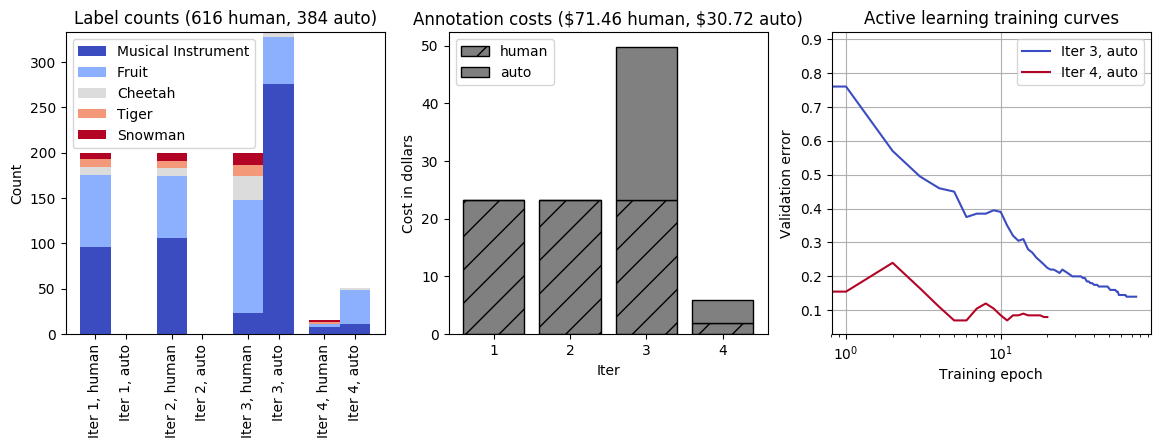

In [14]:
from datetime import datetime
import glob
import shutil
HUMAN_PRICE = 0.116
AUTO_PRICE = 0.08

try:
    os.makedirs('ic_output_data/', exist_ok=False)
except FileExistsError:
    shutil.rmtree('ic_output_data/')
    
S3_OUTPUT = boto3.client('sagemaker').describe_labeling_job(LabelingJobName=job_name)[
    'OutputConfig']['S3OutputPath'] + job_name

# Download human annotation data.
!aws s3 cp {S3_OUTPUT + '/annotations/worker-response'} ic_output_data/worker-response --recursive --quiet
worker_times = []
worker_ids = []

# Collect the times and worker ids of all the annotation events to-date.
for annot_fname in glob.glob('ic_output_data/worker-response/**', recursive=True):
    if annot_fname.endswith('json'):
        with open(annot_fname, 'r') as f:
            annot_data = json.load(f)
        for answer in annot_data['answers']:
            annot_time = datetime.strptime(
                answer['submissionTime'], '%Y-%m-%dT%H:%M:%SZ')
            annot_id = answer['workerId']
            worker_times.append(annot_time)
            worker_ids.append(annot_id)

sort_ids = np.argsort(worker_times)
worker_times = np.array(worker_times)[sort_ids]
worker_ids = np.array(worker_ids)[sort_ids]
cumulative_n_annots = np.cumsum([1 for _ in worker_times])

# Count the number of annotations per unique worker id.
annots_per_worker = np.zeros(worker_ids.size)
ids_store = set()
for worker_id_id, worker_id in enumerate(worker_ids):
    ids_store.add(worker_id)
    annots_per_worker[worker_id_id] = float(
        cumulative_n_annots[worker_id_id]) / len(ids_store)
    
# Count number of human annotations in each class each iteration.
!aws s3 cp {S3_OUTPUT + '/annotations/consolidated-annotation/consolidation-response'} ic_output_data/consolidation-response --recursive --quiet
consolidated_classes = defaultdict(list)
consolidation_times = {}
consolidated_cost_times = []

for consolidated_fname in glob.glob('ic_output_data/consolidation-response/**', recursive=True):
    if consolidated_fname.endswith('json'):
        iter_id = int(consolidated_fname.split('/')[-2][-1])
        # Store the time of the most recent consolidation event as iteration time.
        iter_time = datetime.strptime(consolidated_fname.split('/')[-1], '%Y-%m-%d_%H:%M:%S.json')
        if iter_id in consolidation_times:
            consolidation_times[iter_id] = max(consolidation_times[iter_id], iter_time)
        else:
            consolidation_times[iter_id] = iter_time
        consolidated_cost_times.append(iter_time)
                                      
        with open(consolidated_fname, 'r') as f:
            consolidated_data = json.load(f)
        for consolidation in consolidated_data:
            consolidation_class = consolidation['consolidatedAnnotation']['content'][
                'category-metadata']['class-name']
            consolidated_classes[iter_id].append(consolidation_class)
total_human_labels = sum([len(annots) for annots in consolidated_classes.values()])
            
# Count the number of machine iterations in each class each iteration.
!aws s3 cp {S3_OUTPUT + '/activelearning'} ic_output_data/activelearning --recursive --quiet
auto_classes = defaultdict(list)
auto_times = {}
auto_cost_times = []

for auto_fname in glob.glob('ic_output_data/activelearning/**', recursive=True):
    if auto_fname.endswith('auto_annotator_output.txt'):
        iter_id = int(auto_fname.split('/')[-3])
        with open(auto_fname, 'r') as f:
            annots = [' '.join(l.split()[1:]) for l in f.readlines()]
        for annot in annots:
            annot = json.loads(annot)
            time_str = annot['category-metadata']['creation-date']
            auto_time = datetime.strptime(time_str, '%Y-%m-%dT%H:%M:%S.%f')
            auto_class = annot['category-metadata']['class-name']
            auto_classes[iter_id].append(auto_class)
            if iter_id in auto_times:
                auto_times[iter_id] = max(auto_times[iter_id], auto_time)
            else:
                auto_times[iter_id] = auto_time
            auto_cost_times.append(auto_time)
                
total_auto_labels = sum([len(annots) for annots in auto_classes.values()])
n_iters = max(len(auto_times), len(consolidation_times))

def get_training_job_data(training_job_name):
    logclient = boto3.client('logs')
    log_group_name = '/aws/sagemaker/TrainingJobs'
    log_stream_name = logclient.describe_log_streams(logGroupName=log_group_name,
        logStreamNamePrefix=training_job_name)['logStreams'][0]['logStreamName']
    train_log = logclient.get_log_events(
        logGroupName=log_group_name,
        logStreamName=log_stream_name,
        startFromHead=True
    )
    events = train_log['events']
    next_token = train_log['nextForwardToken']
    while True:
        train_log = logclient.get_log_events(
            logGroupName=log_group_name,
            logStreamName=log_stream_name,
            startFromHead=True,
            nextToken=next_token
        )
        if train_log['nextForwardToken'] == next_token:
            break
        events = events + train_log['events']

    errors = []
    for event in events:
        msg = event['message']
        if 'Final configuration' in msg:
            num_samples = int(msg.split('num_training_samples\': u\'')[1].split('\'')[0])
        elif 'Validation-accuracy' in msg:
            errors.append(float(msg.split('Validation-accuracy=')[1]))

    errors = 1 - np.array(errors)
    return num_samples, errors

training_data = !aws s3 ls {S3_OUTPUT + '/training/'} --recursive
training_sizes = []
training_errors = []
training_iters = []
for line in training_data:
    if line.split('/')[-1] == 'model.tar.gz':
        training_job_name = line.split('/')[-3]
        n_samples, errors = get_training_job_data(training_job_name)
        training_sizes.append(n_samples)
        training_errors.append(errors)
        training_iters.append(int(line.split('/')[-5]))

plt.figure(facecolor='white', figsize=(14, 4), dpi=100)
ax = plt.subplot(131)
plt.title('Label counts ({} human, {} auto)'.format(
    total_human_labels, total_auto_labels))
cmap = plt.get_cmap('coolwarm')
for iter_id in consolidated_classes.keys():
    bottom = 0
    class_counter = Counter(consolidated_classes[iter_id])
    for cname_id, cname in enumerate(CLASS_LIST):
        if iter_id == 1:
            plt.bar(iter_id, class_counter[cname], width=.4, bottom=bottom,
                label=cname, color=cmap(cname_id / float(len(CLASS_LIST)-1)))
        else:
            plt.bar(iter_id, class_counter[cname], width=.4, bottom=bottom,
                color=cmap(cname_id / float(len(CLASS_LIST)-1)))

        bottom += class_counter[cname]
        
for iter_id in auto_classes.keys():
    bottom = 0
    class_counter = Counter(auto_classes[iter_id])
    for cname_id, cname in enumerate(CLASS_LIST):
        plt.bar(iter_id + .4, class_counter[cname], width=.4, bottom=bottom, color=cmap(cname_id / float(len(CLASS_LIST)-1)))
        bottom += class_counter[cname]

tick_labels_human = ['Iter {}, human'.format(iter_id + 1) for iter_id in range(n_iters)]
tick_labels_auto = ['Iter {}, auto'.format(iter_id + 1) for iter_id in range(n_iters)]
tick_locations_human = np.arange(n_iters) + 1
tick_locations_auto = tick_locations_human + .4
tick_labels = np.concatenate([[tick_labels_human[idx], tick_labels_auto[idx]] for idx in range(n_iters)])
tick_locations = np.concatenate([[tick_locations_human[idx], tick_locations_auto[idx]] for idx in range(n_iters)])
plt.xticks(tick_locations, tick_labels, rotation=90)
plt.legend()
plt.ylabel('Count')

ax = plt.subplot(132)
total_human = 0
total_auto = 0
for iter_id in range(1, n_iters + 1):
    cost_human = len(consolidated_classes[iter_id]) * HUMAN_PRICE
    cost_auto = len(auto_classes[iter_id]) * AUTO_PRICE
    total_human += cost_human
    total_auto += cost_auto
    
    plt.bar(iter_id, cost_human, width=.8, color='gray',
            hatch='/', edgecolor='k', label='human' if iter_id==1 else None)
    plt.bar(iter_id, cost_auto, bottom=cost_human,
            width=.8, color='gray', edgecolor='k', label='auto' if iter_id==1 else None)
plt.title('Annotation costs (\${:.2f} human, \${:.2f} auto)'.format(
    total_human, total_auto))
plt.xlabel('Iter')
plt.ylabel('Cost in dollars')
plt.legend()

if len(training_sizes) > 0:
    plt.subplot(133)
    plt.title('Active learning training curves')
    plt.grid(True)

    cmap = plt.get_cmap('coolwarm')
    n_all = len(training_sizes)
    for iter_id_id, (iter_id, size, errs) in enumerate(zip(training_iters, training_sizes, training_errors)):
        plt.plot(errs, label='Iter {}, auto'.format(iter_id + 1), color=cmap(iter_id_id / max(1, (n_all-1))))
        plt.legend()

    plt.xscale('log')
    plt.xlabel('Training epoch')
    plt.ylabel('Validation error')

# Analyze Ground Truth labeling job results
**This section should take about 20min to complete.**

After the job finishes running (**make sure `sagemaker_client.describe_labeling_job` shows the job is complete!**), it is time to analyze the results. The plots in the [Monitor job progress](#Monitor-job-progress) section form part of the analysis. In this section, we will gain additional insights into the results, all contained in the `output manifest`. You can find the location of the output manifest under `AWS Console > SageMaker > Labeling Jobs > [name of your job]`. We will obtain it programmatically in the cell below.

## Postprocess the output manifest
Now that the job is complete, we will download the output manifest manfiest and postprocess it to form four arrays:
* `img_uris` contains the S3 URIs of all the images that Ground Truth annotated.
* `labels` contains Ground Truth's labels for each image in `img_uris`.
* `confidences` contains the confidence of each label in `labels`.
* `human` is a flag array that contains 1 at indices corresponding to images annotated by human annotators, and 0 at indices corresponding to images annotated by Ground Truth's automated data labeling.

In [15]:
# Load the output manifest's annotations.
OUTPUT_MANIFEST = 's3://{}/{}/output/{}/manifests/output/output.manifest'.format(BUCKET, EXP_NAME, job_name)

!aws s3 cp {OUTPUT_MANIFEST} 'output.manifest'

with open('output.manifest', 'r') as f:
    output = [json.loads(line.strip()) for line in f.readlines()]

# Create data arrays.
img_uris = [None] * len(output)
confidences = np.zeros(len(output))
groundtruth_labels = [None] * len(output)
human = np.zeros(len(output))

# Find the job name the manifest corresponds to.
keys = list(output[0].keys())
metakey = keys[np.where([('-metadata' in k) for k in keys])[0][0]]
jobname = metakey[:-9]

# Extract the data.
for datum_id, datum in enumerate(output):
    img_uris[datum_id] = datum['source-ref']
    groundtruth_labels[datum_id] = str(datum[metakey]['class-name'])
    confidences[datum_id] = datum[metakey]['confidence']
    human[datum_id] = int(datum[metakey]['human-annotated'] == 'yes')
groundtruth_labels = np.array(groundtruth_labels)

download: s3://adobe-adcloud/ground-truth-ic-demo/output/ground-truth-demo-1561485422/manifests/output/output.manifest to ./output.manifest


## Plot class histograms
Now, let's plot the class histograms. The next cell should produce three subplots:
* The Left subplot shows the number of images annotated as belonging to each visual category. The categories will be sorted from the most to the least numerous. Each bar is divided into a 'human' and 'machine' part which shows how many images were annotated as given category by human annotators and by the automated data labeling mechanism.

* The Middle subplot is the same as Left, except y-axis is in log-scale. This helps visualize unbalanced datasets where some categories contain orders of magnitude more images than other.

* The Right subplot shows the average confidence of images in each category, separately for human and auto-annotated images.

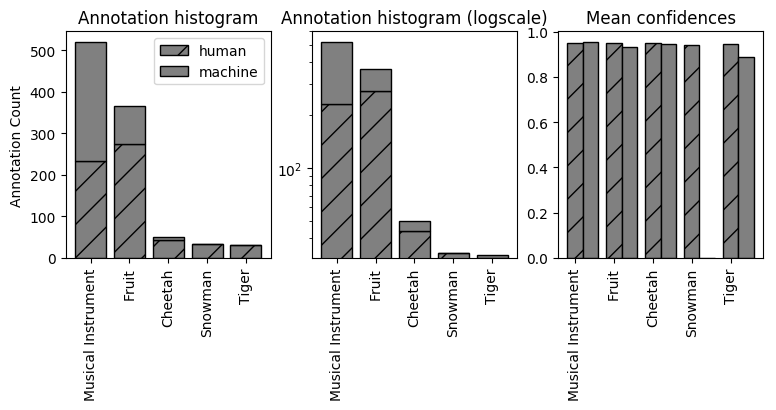

In [16]:
# Compute the number of annotations in each class.
n_classes = len(set(groundtruth_labels))
sorted_clnames, class_sizes = zip(*Counter(groundtruth_labels).most_common(n_classes))

# Find ids of human-annotated images.
human_sizes = [human[groundtruth_labels == clname].sum() for clname in sorted_clnames]
class_sizes = np.array(class_sizes)
human_sizes = np.array(human_sizes)

# Compute the average annotation confidence per class.
human_confidences = np.array([confidences[np.logical_and(groundtruth_labels == clname, human)]
                              for clname in sorted_clnames])
machine_confidences = [confidences[np.logical_and(groundtruth_labels == clname, 1-human)]
                       for clname in sorted_clnames]

# If there is no images annotated as a specific class, set the average class confidence to 0.
for class_id in range(n_classes):
    if human_confidences[class_id].size == 0:
        human_confidences[class_id] = np.array([0])
    if machine_confidences[class_id].size == 0:
        machine_confidences[class_id] = np.array([0])

plt.figure(figsize=(9, 3), facecolor='white', dpi=100)
plt.subplot(1, 3, 1)
plt.title('Annotation histogram')
plt.bar(range(n_classes), human_sizes, color='gray', hatch='/', edgecolor='k', label='human')
plt.bar(range(n_classes), class_sizes - human_sizes, bottom=human_sizes, color='gray', edgecolor='k', label='machine')
plt.xticks(range(n_classes), sorted_clnames, rotation=90)
plt.ylabel('Annotation Count')
plt.legend()

plt.subplot(1, 3, 2)
plt.title('Annotation histogram (logscale)')
plt.bar(range(n_classes), human_sizes, color='gray', hatch='/', edgecolor='k', label='human')
plt.bar(range(n_classes), class_sizes - human_sizes, bottom=human_sizes, color='gray', edgecolor='k', label='machine')
plt.xticks(range(n_classes), sorted_clnames, rotation=90)
plt.yscale('log')

plt.subplot(1, 3, 3)
plt.title('Mean confidences')
plt.bar(np.arange(n_classes), [conf.mean() for conf in human_confidences],
        color='gray', hatch='/', edgecolor='k', width=.4)
plt.bar(np.arange(n_classes) + .4, [conf.mean() for conf in machine_confidences],
        color='gray', edgecolor='k', width=.4)
plt.xticks(range(n_classes), sorted_clnames, rotation=90);

## Plot annotated images
In any data science task, it is crucial to plot and inspect the results to check they make sense. In order to do this, we will 
1. Download the input images that Ground Truth annotated.
2. Split them by annotated category and whether the annotation was done by human or the auto-labeling mechanism.
3. Plot images in each category and human/auto-annoated class.

We will download the input images to `LOCAL_IMAGE_DIR` you can choose in the next cell. Note that if this directory already contains images with the same filenames as your Ground Truth input images, we will not re-download the images.

If your dataset is large and you do not wish to download and plot **all** the images, simply set `DATASET_SIZE` to a small number. We will pick a random subset of your data for plotting.

In [18]:
LOCAL_IMG_DIR = './images' # Replace with the name of a local directory to store images.
assert LOCAL_IMG_DIR != '<< choose a local directory name to download the images to >>', 'Please provide a local directory name'
#DATASET_SIZE = len(img_uris) # Change this to a reasonable number if your dataset much larger than 10K images.
DATASET_SIZE = 100

subset_ids = np.random.choice(range(len(img_uris)), DATASET_SIZE, replace=False)
img_uris = [img_uris[idx] for idx in subset_ids]
groundtruth_labels = groundtruth_labels[subset_ids]
confidences = confidences[subset_ids]
human = human[subset_ids]

img_fnames = [None] * len(output)
for img_uri_id, img_uri in enumerate(img_uris):
    target_fname = os.path.join(
        LOCAL_IMG_DIR, img_uri.split('/')[-1])
    if not os.path.isfile(target_fname):
        !aws s3 cp {img_uri} {target_fname}
    img_fnames[img_uri_id] = target_fname

download: s3://adobe-adcloud/ground-truth-ic-demo/images/02ff509712130d4b.jpg to images/02ff509712130d4b.jpg
download: s3://adobe-adcloud/ground-truth-ic-demo/images/4c609180284c1d01.jpg to images/4c609180284c1d01.jpg
download: s3://adobe-adcloud/ground-truth-ic-demo/images/1265a59916050f73.jpg to images/1265a59916050f73.jpg
download: s3://adobe-adcloud/ground-truth-ic-demo/images/07937478d93ef686.jpg to images/07937478d93ef686.jpg
download: s3://adobe-adcloud/ground-truth-ic-demo/images/0aeb2d73c7b47a54.jpg to images/0aeb2d73c7b47a54.jpg
download: s3://adobe-adcloud/ground-truth-ic-demo/images/1b153b4ebae85924.jpg to images/1b153b4ebae85924.jpg
download: s3://adobe-adcloud/ground-truth-ic-demo/images/552eb7ab19a23c87.jpg to images/552eb7ab19a23c87.jpg
download: s3://adobe-adcloud/ground-truth-ic-demo/images/02189732264c9d0d.jpg to images/02189732264c9d0d.jpg
download: s3://adobe-adcloud/ground-truth-ic-demo/images/081fd131e90e9e11.jpg to images/081fd131e90e9e11.jpg
download: s3://adob

download: s3://adobe-adcloud/ground-truth-ic-demo/images/4dd7fbd10982b2b6.jpg to images/4dd7fbd10982b2b6.jpg
download: s3://adobe-adcloud/ground-truth-ic-demo/images/07a9ef247e338641.jpg to images/07a9ef247e338641.jpg
download: s3://adobe-adcloud/ground-truth-ic-demo/images/00f2cc44022bad7d.jpg to images/00f2cc44022bad7d.jpg
download: s3://adobe-adcloud/ground-truth-ic-demo/images/523ca16e15ae0af6.jpg to images/523ca16e15ae0af6.jpg
download: s3://adobe-adcloud/ground-truth-ic-demo/images/057b80d86d6abbd7.jpg to images/057b80d86d6abbd7.jpg
download: s3://adobe-adcloud/ground-truth-ic-demo/images/148c848ed8e16182.jpg to images/148c848ed8e16182.jpg
download: s3://adobe-adcloud/ground-truth-ic-demo/images/266da5c9859d2cfc.jpg to images/266da5c9859d2cfc.jpg
download: s3://adobe-adcloud/ground-truth-ic-demo/images/48d288293a0e627b.jpg to images/48d288293a0e627b.jpg
download: s3://adobe-adcloud/ground-truth-ic-demo/images/0b237ed8f2da94bf.jpg to images/0b237ed8f2da94bf.jpg
download: s3://adob

### Plot a small output sample
The following cell will create two figures. The first plots `N_SHOW` images in each category, as annotated by humans. The second plots `N_SHOW` images in each category, as annotated by the auto-labeling mechanism. 

If any category contains less than `N_SHOW` images, that row will not be displayed. By default, `N_SHOW = 10`, but feel free to change this to any other small number.

Not enough machine annotations to show for class: Fruit
Not enough machine annotations to show for class: Cheetah
Not enough machine annotations to show for class: Snowman
Not enough machine annotations to show for class: Tiger


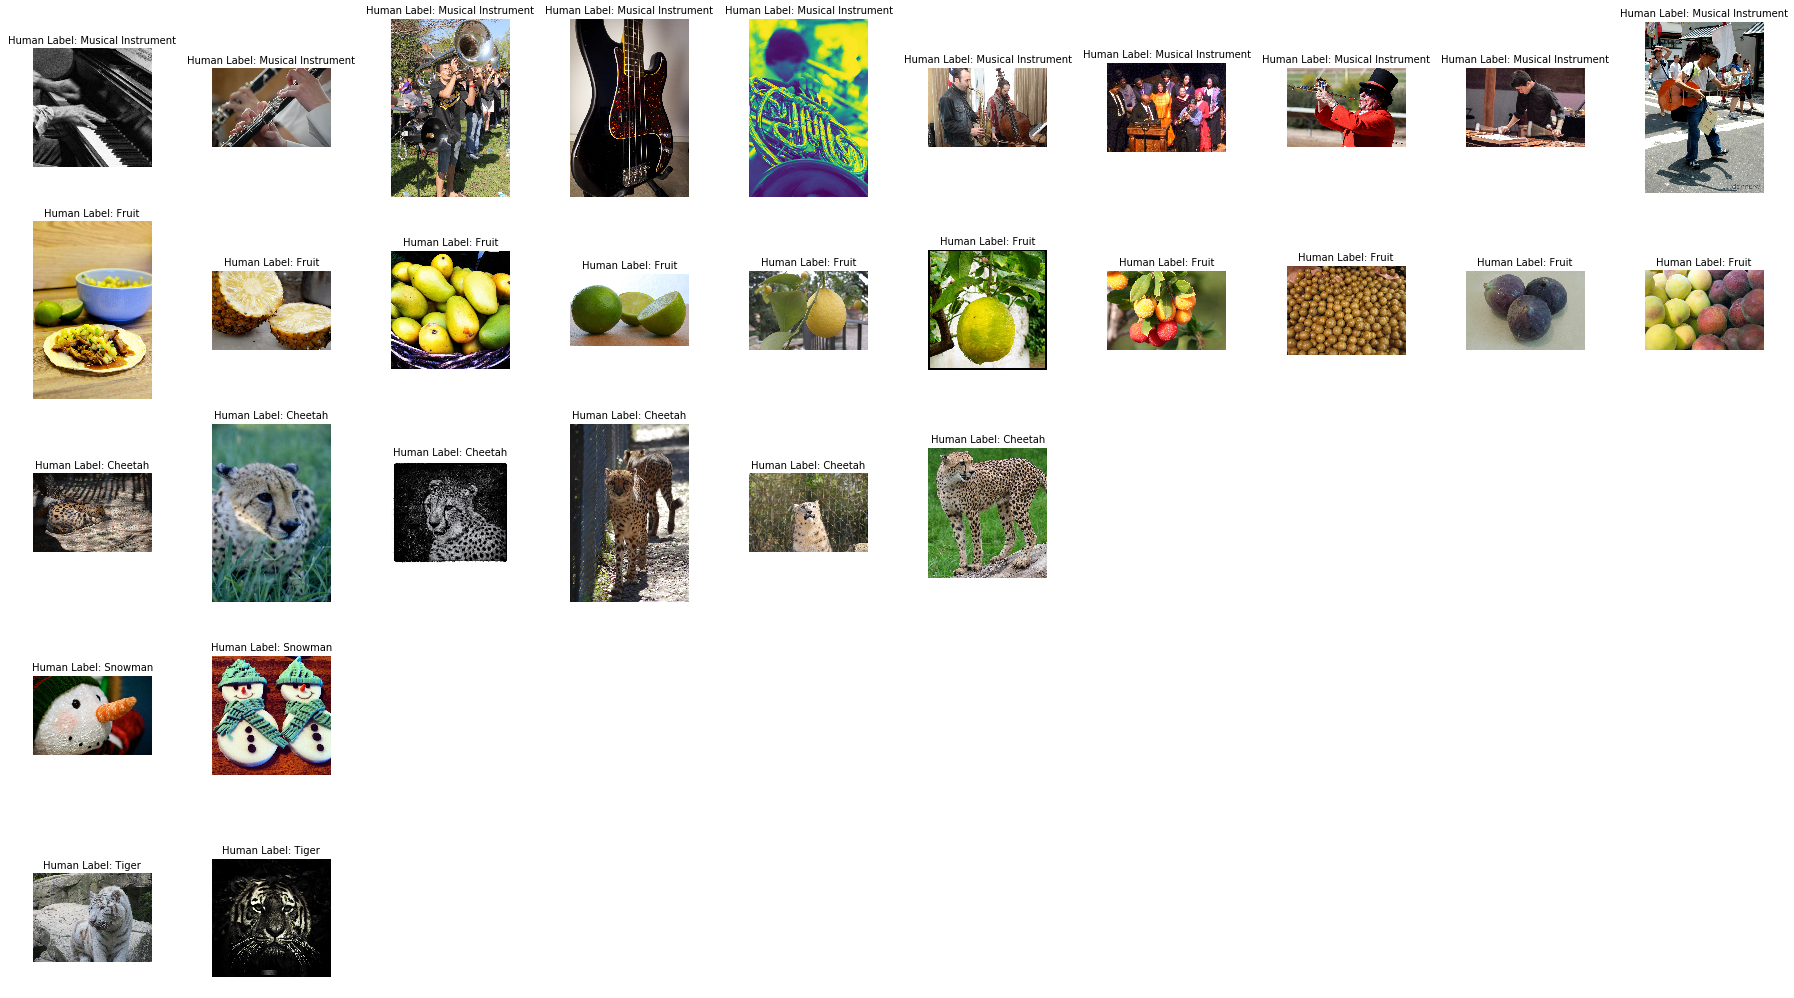

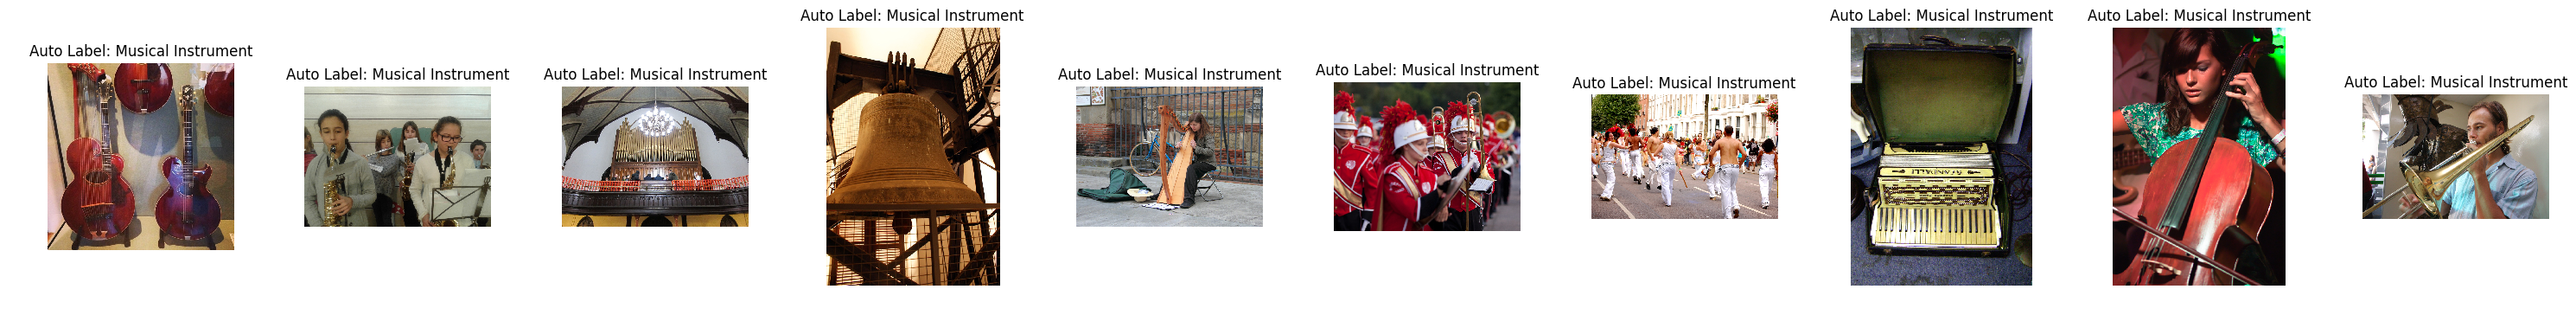

In [19]:
N_SHOW = 10

plt.figure(figsize=(3 * N_SHOW, 2 + 3 * n_classes), facecolor='white', dpi=60)
for class_name_id, class_name in enumerate(sorted_clnames):
    class_ids = np.where(np.logical_and(np.array(groundtruth_labels) == class_name, human))[0]
    try:
        show_ids = class_ids[:N_SHOW]
    except ValueError:
        print('Not enough human annotations to show for class: {}'.format(class_name))
        continue
    for show_id_id, show_id in enumerate(show_ids):
        plt.subplot2grid((n_classes, N_SHOW), (class_name_id, show_id_id))
        plt.title('Human Label: ' + class_name)
        plt.imshow(imageio.imread(img_fnames[show_id])) #image_fnames
        plt.axis('off')
    plt.tight_layout()
    
plt.figure(figsize=(3 * N_SHOW, 2 + 3 * n_classes), facecolor='white', dpi=100)
for class_name_id, class_name in enumerate(sorted_clnames):
    class_ids = np.where(np.logical_and(np.array(groundtruth_labels) == class_name, 1-human))[0]
    try:
        show_ids = np.random.choice(class_ids, N_SHOW, replace=False)
    except ValueError:
        print('Not enough machine annotations to show for class: {}'.format(class_name))
        continue
    for show_id_id, show_id in enumerate(show_ids):
        plt.subplot2grid((n_classes, N_SHOW), (class_name_id, show_id_id))
        plt.title('Auto Label: ' + class_name)
        plt.imshow(imageio.imread(img_fnames[show_id]))
        plt.axis('off')
    plt.tight_layout()

### Plot the full results
Finally, we plot all the results to a large pdf file. The pdf (called `ground_truth.pdf`) will display 100 images per page. Each page will contain images belonging to the same category, and annotated either by human annotators or by the auto-labeling mechanism. You can use this pdf to investigate exactly which images were annotated as which class at a glance.

This might take a while, and the resulting pdf might be very large. For a dataset of 1K images, the process takes only a minute and creates a 10MB-large pdf. You can set `N_SHOW_PER_CLASS` to a small number if you want to limit the max number of examples shown in each category.

In [22]:
N_SHOW_PER_CLASS = np.inf
plt.figure(figsize=(10, 10), facecolor='white', dpi=100)

with PdfPages('ground_truth.pdf') as pdf:
    for class_name in sorted_clnames:
        # Plot images annotated as class_name by humans.
        plt.clf()
        plt.text(0.1, 0.5, s='Images annotated as {} by humans'.format(class_name), fontsize=20)
        plt.axis('off')
        
        class_ids = np.where(np.logical_and(np.array(groundtruth_labels) == class_name, human))[0]
        for img_id_id, img_id in enumerate(class_ids):
            if img_id_id == N_SHOW_PER_CLASS:
                break
            if img_id_id % 100 == 0:
                pdf.savefig()
                plt.clf()
                print('Plotting human annotations of {}, {}/{}...'.format(
                    class_name, (img_id_id + 1), min(len(class_ids), N_SHOW_PER_CLASS)))
            plt.subplot(10, 10, (img_id_id % 100) + 1)
            plt.imshow(imageio.imread(img_fnames[img_id]), aspect='auto')
            plt.axis('off')
        pdf.savefig()
            
        # Plot images annotated as class_name by machines.
        plt.clf()
        plt.text(0.1, 0.5, s='Images annotated as {} by machines'.format(class_name), fontsize=20)
        plt.axis('off')
        
        class_ids = np.where(np.logical_and(np.array(groundtruth_labels) == class_name, 1-human))[0]
        for img_id_id, img_id in enumerate(class_ids):
            if img_id_id == N_SHOW_PER_CLASS:
                break
            if img_id_id % 100 == 0:
                pdf.savefig()
                plt.clf()
                print('Plotting machine annotations of {}, {}/{}...'.format(
                    class_name, (img_id_id + 1), min(len(class_ids), N_SHOW_PER_CLASS)))
            plt.subplot(10, 10, (img_id_id % 100) + 1)
            plt.imshow(imageio.imread(img_fnames[img_id]), aspect='auto')
            plt.axis('off')
        pdf.savefig()
plt.clf()

Plotting human annotations of Musical Instrument, 1/21...
Plotting machine annotations of Musical Instrument, 1/36...
Plotting human annotations of Fruit, 1/24...
Plotting machine annotations of Fruit, 1/9...
Plotting human annotations of Cheetah, 1/6...
Plotting human annotations of Snowman, 1/2...
Plotting human annotations of Tiger, 1/2...


<Figure size 1000x1000 with 0 Axes>

# Compare Ground Truth results to known, pre-labeled data
**This section should take about 5 minutes to complete.**

Sometimes (for example, when benchmarking the system) we have an alternative set of data labels available. 
For example, the Open Images data has already been carefully annotated by a professional annotation workforce.
This allows us to perform additional analysis that compares Ground Truth labels to the known, pre-labeled data.
When doing so, it is important to bear in mind that any image labels created by humans
will most likely not be 100% accurate. For this reason, it is better to think of labeling accuracy as
"adherence to a particular standard / set of labels" rather than "how good (in absolute terms) are the Ground Truth labels."

## Compute accuracy
In this cell, we will calculate the accuracy of Ground Truth labels with respect to the standard labels. 

In [Prepare the data](#Prepare-the-data), we created the `ims` dictionary that specifies which image belongs to each category.
We will convert it to an array `standard_labels` such that `standard_labels[i]` contains the label of the `i-th` image, and
should ideally correspond to `groundtruth_labels[i]`.

This will allow us to plot confusion matrices to assess how well the Ground Truth labels adhere to the standard labels. We plot a confusion matrix for the total dataset, and separate matrices for human annotations and auto-annotations.

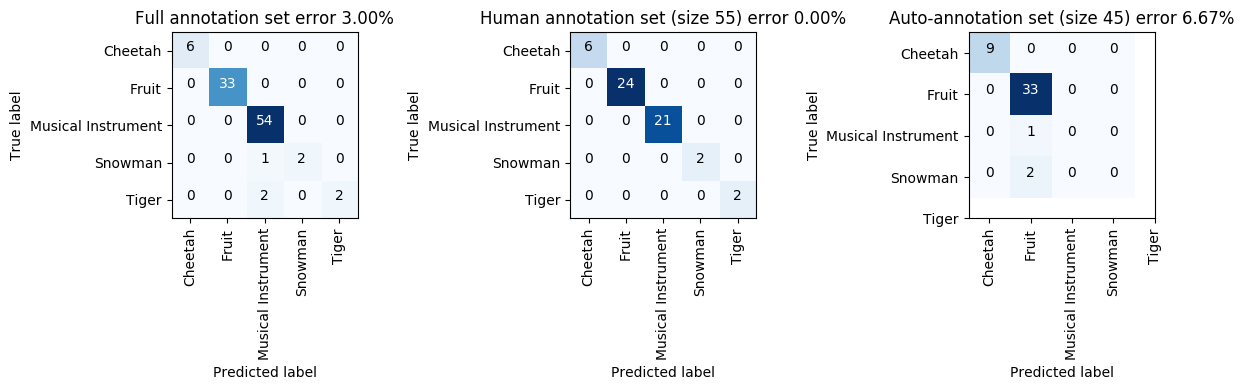

In [23]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j].astype(int), fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# Convert the 'ims' dictionary (which maps class names to images) to a list of image classes.
standard_labels = []
for img_uri in img_uris:
    img_uri = img_uri.split('/')[-1].split('.')[0]
    standard_label = [cname for cname, imgs_in_cname in ims.items() if img_uri in imgs_in_cname][0]
    standard_labels.append(standard_label)
standard_labels = np.array(standard_labels)

# Plot a confusion matrix for the full dataset.
plt.figure(facecolor='white', figsize=(12, 4), dpi=100)
plt.subplot(131)
mean_err = 100 - np.mean(standard_labels == groundtruth_labels) * 100
cnf_matrix = confusion_matrix(standard_labels, groundtruth_labels)

np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=sorted(ims.keys()),
                      title='Full annotation set error {:.2f}%'.format(
                          mean_err), normalize=False)

# Plot a confusion matrix for human-annotated Ground Truth labels.
plt.subplot(132)
mean_err = 100 - np.mean(standard_labels[human==1.] == groundtruth_labels[human==1.]) * 100
cnf_matrix = confusion_matrix(standard_labels[human==1.], groundtruth_labels[human==1.])
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=sorted(ims.keys()),
                      title='Human annotation set (size {}) error {:.2f}%'.format(
                          int(sum(human)), mean_err), normalize=False)

# Plot a confusion matrix for auto-annotated Ground Truth labels.
if sum(human==0.) > 0:
    plt.subplot(133)
    mean_err = 100 - np.mean(standard_labels[human==0.] == groundtruth_labels[human==0.]) * 100
    cnf_matrix = confusion_matrix(standard_labels[human==0.], groundtruth_labels[human==0.])
    np.set_printoptions(precision=2)
    plot_confusion_matrix(cnf_matrix, classes=sorted(ims.keys()),
                          title='Auto-annotation set (size {}) error {:.2f}%'.format(
                              int(len(human) - sum(human)), mean_err), normalize=False)

## Plot correct and incorrect annotations

This cell repeats the plot from Plot the full results. However, it sorts the predictions into correct and incorrect, and indicates the standard label of all the incorrect predictions.


In [24]:
N_SHOW_PER_CLASS = np.inf
plt.figure(figsize=(10, 10), facecolor='white', dpi=100)

with PdfPages('ground_truth_benchmark.pdf') as pdf:
    for class_name in sorted_clnames:
        human_ids = np.where(np.logical_and(np.array(groundtruth_labels) == class_name, human))[0]
        auto_ids = np.where(np.logical_and(np.array(groundtruth_labels) == class_name, 1-human))[0]
        for class_ids_id, class_ids in enumerate([human_ids, auto_ids]):
            plt.clf()
            plt.text(0.1, 0.5, s='Images annotated as {} by {}'.format(class_name, 'humans' if class_ids_id == 0 else 'machines'), fontsize=20)
            plt.axis('off')

            good_ids = class_ids[np.where(standard_labels[class_ids] == groundtruth_labels[class_ids])[0]]
            bad_ids = class_ids[np.where(standard_labels[class_ids] != groundtruth_labels[class_ids])[0]]
            for img_id_id, img_id in enumerate(np.concatenate([good_ids, bad_ids])):
                if img_id_id == N_SHOW_PER_CLASS:
                    break
                if img_id_id % 100 == 0:
                    pdf.savefig()
                    plt.clf()
                    print('Plotting annotations of {}, {}/{}...'.format(
                        class_name, img_id_id, min(len(class_ids), N_SHOW_PER_CLASS)))
                ax = plt.subplot(10, 10, (img_id_id % 100) + 1)
                plt.imshow(imageio.imread(img_fnames[img_id]), aspect='auto')
                plt.axis('off')
                if img_id_id < len(good_ids):
                    # Draw a green border around the image.
                    rec = matplotlib.patches.Rectangle((0, 0), 1, 1, lw=10,
                                                       edgecolor='green', fill=False,
                                                       transform=ax.transAxes)
                else:
                    # Draw a red border around the image.
                    rec = matplotlib.patches.Rectangle((0, 0), 1, 1, lw=10,
                                   edgecolor='red', fill=False,
                                   transform=ax.transAxes)
                ax.add_patch(rec)
            pdf.savefig()
plt.clf()

Plotting annotations of Musical Instrument, 0/21...
Plotting annotations of Musical Instrument, 0/36...
Plotting annotations of Fruit, 0/24...
Plotting annotations of Fruit, 0/9...
Plotting annotations of Cheetah, 0/6...
Plotting annotations of Snowman, 0/2...
Plotting annotations of Tiger, 0/2...


<Figure size 1000x1000 with 0 Axes>

# Train an image classifier using Ground Truth labels
At this stage, we have fully labeled our dataset and we can train a machine learning model to classify images based on the categories we previously defined. We'll do so using the **augmented manifest** output of our labeling job - no additional file translation or manipulation required! For a more complete description of the augmented manifest, see our other [example notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/ground_truth_labeling_jobs/object_detection_augmented_manifest_training/object_detection_augmented_manifest_training.ipynb).

**NOTE:** Training neural networks to high accuracy often requires a careful choice of hyperparameters. In this case, we hand-picked hyperparameters that work reasonably well for this dataset. The neural net should have accuracy of about **60% if you're using 100 datapoints, and over 95% if you're using 1000 datapoints.**. To train neural networks on novel data, consider using [SageMaker's model tuning / hyperparameter optimization algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html).

First, we'll split our augmented manifest into a training set and a validation set using an 80/20 split.

In [25]:
with open('output.manifest', 'r') as f:
    output = [json.loads(line) for line in f.readlines()]

# Shuffle output in place.
np.random.shuffle(output)
    
dataset_size = len(output)
train_test_split_index = round(dataset_size*0.8)

train_data = output[:train_test_split_index]
validation_data = output[train_test_split_index:]

num_training_samples = 0
with open('train.manifest', 'w') as f:
    for line in train_data:
        f.write(json.dumps(line))
        f.write('\n')
        num_training_samples += 1
    
with open('validation.manifest', 'w') as f:
    for line in validation_data:
        f.write(json.dumps(line))
        f.write('\n')

Next, we'll upload these manifest files to the previously defined S3 bucket so that they can be used in the training job.

In [26]:
s3.upload_file('train.manifest',BUCKET, EXP_NAME + '/train.manifest')
s3.upload_file('validation.manifest',BUCKET, EXP_NAME + '/validation.manifest')

In [27]:
# Create unique job name 
nn_job_name_prefix = 'groundtruth-augmented-manifest-demo'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
nn_job_name = nn_job_name_prefix + timestamp

training_image = sagemaker.amazon.amazon_estimator.get_image_uri(boto3.Session().region_name, 'image-classification', repo_version='latest')

training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "Pipe"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/{}/output/'.format(BUCKET, EXP_NAME)
    },
    "ResourceConfig": {
        "InstanceCount": 1,   
        "InstanceType": "ml.p3.2xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": nn_job_name,
    "HyperParameters": {
        "epochs": "30",
        "image_shape": "3,224,224",
        "learning_rate": "0.01",
        "lr_scheduler_step": "10,20",
        "mini_batch_size": "32",
        "num_classes": str(num_classes),
        "num_layers": "18",
        "num_training_samples": str(num_training_samples),
        "resize": "224",
        "use_pretrained_model": "1"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 86400
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "AugmentedManifestFile",
                    "S3Uri": 's3://{}/{}/{}'.format(BUCKET, EXP_NAME, 'train.manifest'),
                    "S3DataDistributionType": "FullyReplicated",
                    "AttributeNames": ["source-ref","category"]
                }
            },
            "ContentType": "application/x-recordio",
            "RecordWrapperType": "RecordIO",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "AugmentedManifestFile",
                    "S3Uri": 's3://{}/{}/{}'.format(BUCKET, EXP_NAME, 'validation.manifest'),
                    "S3DataDistributionType": "FullyReplicated",
                    "AttributeNames": ["source-ref","category"]
                }
            },
            "ContentType": "application/x-recordio",
            "RecordWrapperType": "RecordIO",
            "CompressionType": "None"
        }
    ]
}

Now we create the SageMaker training job.

In [28]:
sagemaker_client = boto3.client('sagemaker')
sagemaker_client.create_training_job(**training_params)

# Confirm that the training job has started
print('Transform job started')
while(True):
    status = sagemaker_client.describe_training_job(TrainingJobName=nn_job_name)['TrainingJobStatus']
    if status == 'Completed':
        print("Transform job ended with status: " + status)
        break
    if status == 'Failed':
        message = response['FailureReason']
        print('Transform failed with the following error: {}'.format(message))
        raise Exception('Transform job failed') 
    time.sleep(30)

Transform job started
Transform job ended with status: Completed


# Deploy the Model 

Now that we've fully labeled our dataset and have a trained model, we want to use the model to perform inference.

Image classification only supports encoded .jpg and .png image formats as inference input for now. The output is the probability values for all classes encoded in JSON format, or in JSON Lines format for batch transform.

This section involves several steps,

    Create Model - Create model for the training output
    Batch Transform - Create a transform job to perform batch inference.
    Host the model for realtime inference - Create an inference endpoint and perform realtime inference.

## Create Model

In [29]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
model_name="groundtruth-demo-ic-model" + timestamp
print(model_name)
info = sagemaker_client.describe_training_job(TrainingJobName=nn_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': training_image,
    'ModelDataUrl': model_data,
}

create_model_response = sagemaker_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

groundtruth-demo-ic-model-2019-06-28-21-30-54
s3://adobe-adcloud/ground-truth-ic-demo/output/groundtruth-augmented-manifest-demo-2019-06-27-04-18-10/output/model.tar.gz
arn:aws:sagemaker:us-east-1:328296961357:model/groundtruth-demo-ic-model-2019-06-28-21-30-54


## Batch Transform
We now create a SageMaker Batch Transform job using the model created above to perform batch prediction.

### Download Test Data
First, let's download a test image that has been held out from the training and validation data.

In [30]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
batch_job_name = "image-classification-model" + timestamp
batch_input = 's3://{}/{}/test/'.format(BUCKET, EXP_NAME)
batch_output = 's3://{}/{}/{}/output/'.format(BUCKET, EXP_NAME, batch_job_name)

# Copy two images from each class, unseen by the neural net, to a local bucket.
test_images = []
for class_id in ['/m/04szw', '/m/02xwb', '/m/0cd4d', '/m/07dm6', '/m/0152hh']:
    test_images.extend([label[0] + '.jpg' for label in all_labels if (label[2] == class_id and label[3] == '1')][-2:])
    
!aws s3 rm $batch_input --recursive
for test_img in test_images:
    !aws s3 cp s3://open-images-dataset/test/{test_img} {batch_input}

copy: s3://open-images-dataset/test/ffeaf3fd809336cf.jpg to s3://adobe-adcloud/ground-truth-ic-demo/test/ffeaf3fd809336cf.jpg
copy: s3://open-images-dataset/test/ffec3aa222dfc2d1.jpg to s3://adobe-adcloud/ground-truth-ic-demo/test/ffec3aa222dfc2d1.jpg
copy: s3://open-images-dataset/test/ffd67fbe00f7b500.jpg to s3://adobe-adcloud/ground-truth-ic-demo/test/ffd67fbe00f7b500.jpg
copy: s3://open-images-dataset/test/fffa09609c227c6f.jpg to s3://adobe-adcloud/ground-truth-ic-demo/test/fffa09609c227c6f.jpg
copy: s3://open-images-dataset/test/f1a745fb9367ab13.jpg to s3://adobe-adcloud/ground-truth-ic-demo/test/f1a745fb9367ab13.jpg
copy: s3://open-images-dataset/test/f3f808117f2c0c8e.jpg to s3://adobe-adcloud/ground-truth-ic-demo/test/f3f808117f2c0c8e.jpg
copy: s3://open-images-dataset/test/e9c88dc5f7c66ead.jpg to s3://adobe-adcloud/ground-truth-ic-demo/test/e9c88dc5f7c66ead.jpg
copy: s3://open-images-dataset/test/ff7abc612e454eae.jpg to s3://adobe-adcloud/ground-truth-ic-demo/test/ff7abc612e454

In [31]:
request = \
{
    "TransformJobName": batch_job_name,
    "ModelName": model_name,
    "MaxConcurrentTransforms": 16,
    "MaxPayloadInMB": 6,
    "BatchStrategy": "SingleRecord",
    "TransformOutput": {
        "S3OutputPath": 's3://{}/{}/{}/output/'.format(BUCKET, EXP_NAME, batch_job_name)
    },
    "TransformInput": {
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": batch_input
            }
        },
        "ContentType": "application/x-image",
        "SplitType": "None",
        "CompressionType": "None"
    },
    "TransformResources": {
            "InstanceType": "ml.p2.xlarge",
            "InstanceCount": 1
    }
}

print('Transform job name: {}'.format(batch_job_name))

Transform job name: image-classification-model-2019-06-28-21-31-21


In [32]:
sagemaker_client = boto3.client('sagemaker')
sagemaker_client.create_transform_job(**request)

print("Created Transform job with name: ", batch_job_name)

while(True):
    response = sagemaker_client.describe_transform_job(TransformJobName=batch_job_name)
    status = response['TransformJobStatus']
    if status == 'Completed':
        print("Transform job ended with status: " + status)
        break
    if status == 'Failed':
        message = response['FailureReason']
        print('Transform failed with the following error: {}'.format(message))
        raise Exception('Transform job failed') 
    time.sleep(30)

Created Transform job with name:  image-classification-model-2019-06-28-21-31-21
Transform job ended with status: Completed


After the job completes, let's inspect the prediction results. 

rm: cannot remove ‘test_inputs/*’: No such file or directory
download: s3://adobe-adcloud/ground-truth-ic-demo/image-classification-model-2019-06-28-21-31-21/output/e879f09e65bdc6ff.jpg.out to ./e879f09e65bdc6ff.jpg.out
s3://adobe-adcloud/ground-truth-ic-demo/image-classification-model-2019-06-28-21-31-21/output/e879f09e65bdc6ff.jpg.out
Result: label - Snowman, probability - 0.9714625477790833
download: s3://adobe-adcloud/ground-truth-ic-demo/image-classification-model-2019-06-28-21-31-21/output/e9c88dc5f7c66ead.jpg.out to ./e9c88dc5f7c66ead.jpg.out
s3://adobe-adcloud/ground-truth-ic-demo/image-classification-model-2019-06-28-21-31-21/output/e9c88dc5f7c66ead.jpg.out
Result: label - Cheetah, probability - 0.9936709403991699
download: s3://adobe-adcloud/ground-truth-ic-demo/image-classification-model-2019-06-28-21-31-21/output/f144e3612dc452ec.jpg.out to ./f144e3612dc452ec.jpg.out
s3://adobe-adcloud/ground-truth-ic-demo/image-classification-model-2019-06-28-21-31-21/output/f144e3612dc452

Text(0.5, 0.98, 'Predictions sorted by confidence.')

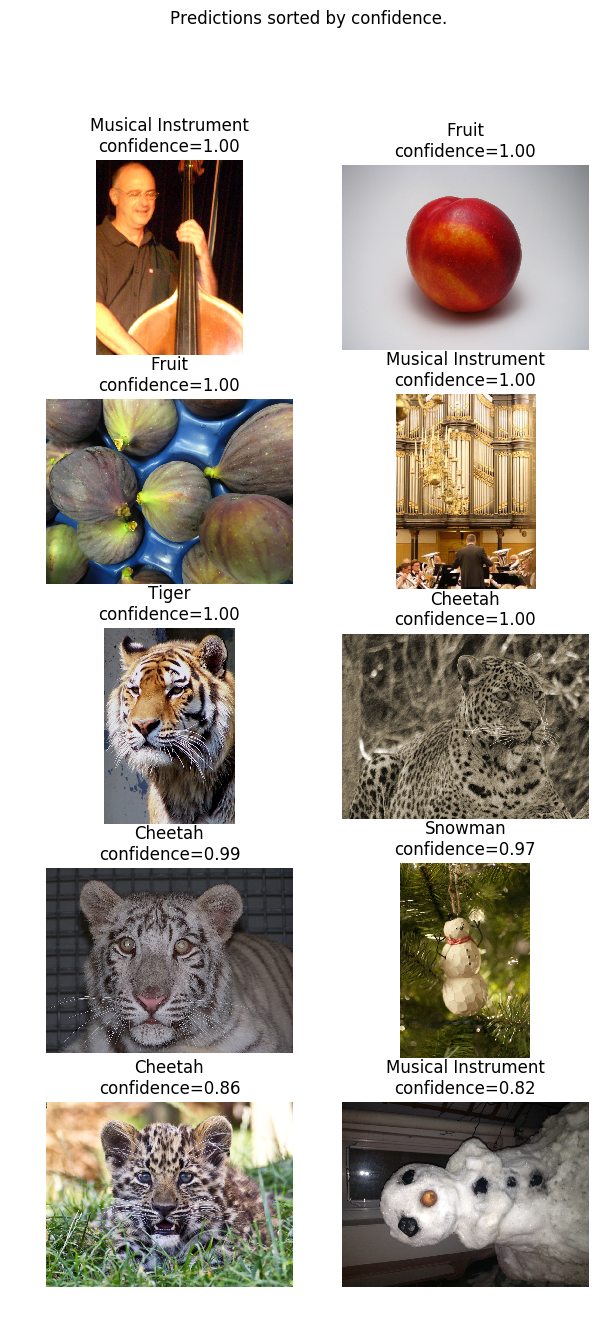

In [33]:
def get_label(out_fname):
    !aws s3 cp {out_fname} .
    print(out_fname)
    with open(out_fname.split('/')[-1]) as f:
        data = json.load(f)
        index = np.argmax(data['prediction'])
        probability = data['prediction'][index]
    print("Result: label - " + CLASS_LIST[index] + ", probability - " + str(probability))
    input_fname = out_fname.split('/')[-1][:-4]
    return CLASS_LIST[index], probability, input_fname

# Show prediction results.
!rm test_inputs/*
plt.figure(facecolor='white', figsize=(7, 15), dpi=100)
outputs = !aws s3 ls {batch_output}
outputs = [get_label(batch_output + prefix.split()[-1]) for prefix in outputs]
outputs.sort(key=lambda pred: pred[1], reverse=True)

for fname_id, (pred_cname, pred_conf, pred_fname) in enumerate(outputs):
    !aws s3 cp {batch_input}{pred_fname} test_inputs/{pred_fname}
    plt.subplot(5, 2, fname_id+1) 
    img = imageio.imread('test_inputs/{}'.format(pred_fname))
    plt.imshow(img)
    plt.axis('off')
    plt.title('{}\nconfidence={:.2f}'.format(pred_cname, pred_conf))
    
if RUN_FULL_AL_DEMO:
    warning = ''
else:
    warning = ('\nNOTE: In this small demo we only used 80 images to train the neural network.\n'
               'The predictions will be far from perfect! Set RUN_FULL_AL_DEMO=True to see properly trained results.')
plt.suptitle('Predictions sorted by confidence.{}'.format(warning))

## Realtime Inference

We now host the model with an endpoint and perform realtime inference.

This section involves several steps,

    Create endpoint configuration - Create a configuration defining an endpoint.
    Create endpoint - Use the configuration to create an inference endpoint.
    Perform inference - Perform inference on some input data using the endpoint.
    Clean up - Delete the endpoint and model

## Create Endpoint Configuration

In [34]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name + '-epc' + timestamp
endpoint_config_response = sagemaker_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: ground-truth-demo-1561485422-epc-2019-06-28-21-40-27
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:328296961357:endpoint-config/ground-truth-demo-1561485422-epc-2019-06-28-21-40-27


## Create Endpoint

Lastly, the customer creates the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes about 10 minutes to complete.

In [35]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name + '-ep' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker_client.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

# get the status of the endpoint
response = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))

# wait until the status has changed
sagemaker_client.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)

# print the status of the endpoint
endpoint_response = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

Endpoint name: ground-truth-demo-1561485422-ep-2019-06-28-21-40-42
EndpointArn = arn:aws:sagemaker:us-east-1:328296961357:endpoint/ground-truth-demo-1561485422-ep-2019-06-28-21-40-42
EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


In [36]:
with open('test_inputs/{}'.format(test_images[0]), 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)

client = boto3.client('sagemaker-runtime')
response = client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)

# `response` comes in a json format, let's unpack it.
result = json.loads(response['Body'].read())
# The result outputs the probabilities for all classes.
# Find the class with maximum probability and print the class name.
print('Model prediction is: {}'.format(CLASS_LIST[np.argmax(result)]))

Model prediction is: Musical Instrument


Finally, let's clean up and delete this endpoint.

In [37]:
sagemaker_client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': 'ed35458c-fbb1-41a3-951b-1f9db7ccac56',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ed35458c-fbb1-41a3-951b-1f9db7ccac56',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sat, 29 Jun 2019 00:09:10 GMT'},
  'RetryAttempts': 0}}

# Review

We covered a lot of ground in this notebook! Let's recap what we accomplished. First we started with an unlabeled dataset (technically, the dataset was previously labeled by the authors of the dataset, but we discarded the original labels for the purposes of this demonstration). Next, we created a SageMake Ground Truth labeling job and generated new labels for all of the images in our dataset. Then we split this file into a training set and a validation set and trained a SageMaker image classification model. Finally, we created a hosted model endpoint and used it to make a live prediction for a held-out image in the original dataset.